In [35]:
import qtensor
import numpy as np
import xarray

import cartesian_explorer as caex
import networkx as nx
import socket # used to determine hostname

## Set up computation environment

In [36]:
# Set up cache directory
cache = caex.caches.JobLibCache("../caex_cache")

# Set up parallel environment based on machine
if socket.gethostname().startswith('skylake'):
    print('Using ray parallel for caex')
    parallel = caex.parallels.Ray(processes=55)
    # Since we will parallelize over graph instances, there's no sense to
    # use multithreaded Gurobi
    GUROBI_THREADS = 1 #set to 0 to use all available
else:
    # Cartesian explorer without parallelization
    parallel = None
    GUROBI_THREADS = 0
ex = caex.Explorer(cache=cache, parallel=parallel)

2021-06-13 16:35:51,678	ERROR worker.py:660 -- Calling ray.init() again after it has already been called.


Using ray parallel for caex


## Generate the data

In [37]:
@ex.provider
def graph(N, seed=10):
    return qtensor.toolbox.random_graph(nodes=N, seed=seed, degree=3)

@ex.provider
def gurobi_cost(graph):
    c, sol = qtensor.tools.maxcut.gurobi_maxcut(graph, max_time=65*60, threads=GUROBI_THREADS)
    return c

In [38]:
# these values have to match ones from ./QAOA solutions vs N.ipynb
Ns = [2**x for x in range(3, 9)]
seeds = range(10, 10+32)

In [39]:
data = ex.map_variables(('gurobi_cost',)
                        , N=Ns
                        , seed=seeds
                        )

### Check the data

In [40]:
import xarray as xar
import matplotlib.pyplot as plt
data.shape

(1, 6, 32)

In [41]:
xd = xar.DataArray(data[0], dims=('N', 'seed'), coords=(Ns, seeds))

Text(0.5, 1.0, 'Cost per node')

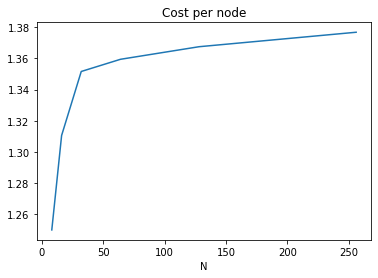

In [42]:
(xd.mean('seed')/Ns).plot()
plt.title('Cost per node')

### Save the data


In [43]:
xd.to_netcdf('../gurobi_cost_vs_N.nc')

---

## Gurobi activation

Get your license here https://www.gurobi.com/downloads/licenses/

In [6]:
import socket

if socket.gethostname() == 'DESKTOP-1OG5J92':
    gurobi_lic = '/home/plate/git-built/gurobi/'
    print('getting license')
    grbkey = '119a6834-b2ea-11eb-97fc-0242ac130002'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey
    
elif socket.gethostname().startswith('skylake'):
    gurobi_lic = '/home/danlkv/git-build/gurobi/'
    print('getting license')
    grbkey = '70dc8be2-b222-11eb-8392-0242ac120002'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey

getting license
info  : grbgetkey version 9.1.2, build v9.1.2rc0
info  : Contacting Gurobi license server...
info  : License file for license ID 630883 was successfully retrieved
info  : License expires at the end of the day on 2021-07-10
info  : Saving license file...
info  : License 630883 written to file /home/danlkv/git-build/gurobi/gurobi.lic
